In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from z3 import *
import time

In [2]:
circ = QuantumCircuit().from_qasm_file('test.qasm')

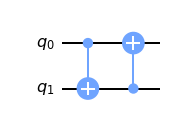

In [3]:
circ.draw('mpl')

In [4]:
def is_diagonal(U):
    i, j = np.nonzero(U)
    return np.all(i == j)

def add_hyper_index(var_list,hyper_index):
    for var in var_list:
        if not var in hyper_index:
            hyper_index[var]=0
            
def reshape(U):
    if U.shape==(2,2):
        return U
    
    if U.shape[0]==U.shape[1]:
        split_U=np.split(U,2,1)
    else:
        split_U=np.split(U,2,0)
    split_U[0]=reshape(split_U[0])
    split_U[1]=reshape(split_U[1]) 
    return np.array([split_U])[0]            
            
def get_real_qubit_num(cir):
    """Calculate the real number of qubits of a circuit"""
    gates=cir.data
    q=0
    for k in range(len(gates)):
        q=max(q,max([qbit.index for qbit in gates[k][1]]))
    return q+1

In [5]:
class Term:
    def __init__(self, attr=0.+0.j, ref=None):
        self.attr = attr
        self.ref = ref
    def tensor(self, t1=None):
        attr1 = self.attr * t1.attr
        ref1 = And(self.ref, t1.ref)
        return Term(attr1, ref1)
#     def equalattr(self, t1=None):
#         return self.attr == t1.attr
#     def equalref(self, t1=None):
#         # check ref equivalence
#         return False
#     def contra(self, t1=None):
#         # check conrtradictoriness
#         return False
#     def shrink(self):
#         # simplify ref
#         pass
#     def reduce(self, t1=None):
#         if self.equalref(t1):
#             return Term(self.attr+t1.attr, self.ref)
#         elif self.contra(t1) and self.equalattr(t1):
#             pass
#         pass

In [6]:
def genRef(r, c, input_qubits, var_list, tt_input_num, bias):
#     print(tt_input_num)
    input_vars = bin(r)[2:]
    if len(input_vars) < input_qubits:
        input_vars = '0'*(input_qubits-len(input_vars)) + input_vars
    output_vars = bin(c)[2:]
    if len(output_vars) < input_qubits:
        output_vars = '0'*(input_qubits-len(output_vars)) + output_vars
    reslist = []
    for i,e in enumerate(input_vars):
        if e == '1':
#             res = And(res, var_list[i])
            reslist.append(var_list[i+bias])
        else:
#             res = And(res, Not(var_list[i]))
            reslist.append(Not(var_list[i+bias]))
    for i,e in enumerate(output_vars):
        if e == '1':
#             res = And(res, var_list[i+vars_num])
            reslist.append(var_list[i+bias+tt_input_num])
        else:
#             res = And(res, Not(var_list[i+vars_num]))
            reslist.append(Not(var_list[i+bias+tt_input_num]))
    return And(tuple(reslist))

In [7]:
class CVBE:
    def __init__(self, termlist=[], termdict={}): # Assume that terms are already regularized
        if termlist != []:
            self.termdict = self.gen_termdict(termlist)
        else:
            self.termdict = termdict
    def gen_termdict(self, termlist):
        termdict = {}
        for term in termlist:
            if term.attr not in termdict:
                termdict[term.attr] = [term]
            else:
                termdict[term.attr].append(term)
        for attr in termdict:
            if len(termdict[attr]) > 1:
                term_rd = Term(attr, Or(tuple([t.ref for t in termdict[attr]])))
                termdict[attr] = term_rd
            else:
                termdict[attr] = termdict[attr][0]
        return termdict
    def regularize(self):
        pass
    def equal(self, c1):
        pass
    def tensor(self, c1):
        termlist1 = []
        for term1 in self.termdict.values():
            for term2 in c1.termdict.values():
                termlist1.append(term1.tensor(term2))
        return CVBE(termlist1)
    def seq(self, c1):
        pass

In [8]:
qubits_num = get_real_qubit_num(circ)
vars_num = qubits_num
var_list = []
for i in range(2*vars_num):
    var_list.append(Bool(str(i)))

<ipython-input-4-77c3d43aa436>:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q=max(q,max([qbit.index for qbit in gates[k][1]]))


In [9]:
# number of gates
gates = circ.data

In [10]:
circ_cvbe = None
for k in range(len(gates)):
    g=gates[k] # information of the kth gate
    nam=g[0].name
    q = [q.index for q in g[1]] # involved qubits of the gate
    print(g, nam, q)
    U = Operator(g[0]).data
    termlist = []
#     print(U.shape)
    for r in range(U.shape[0]):
        for c in range(U.shape[1]):
            if U[r][c] != 0:
                ref = genRef(r,c,len(q), var_list, vars_num, q[0])
                termlist.append(Term(U[r][c], ref))
    cvbe = CVBE(termlist)
#     print(cvbe.termdict[0.7071067811865475+0j].ref)
#     print(cvbe.termdict[-0.7071067811865475+0j].ref)
    if circ_cvbe == None:
        circ_cvbe = cvbe
    else:
        circ_cvbe = circ_cvbe.tensor(cvbe)

<ipython-input-10-cb8acb3fcd4e>:5: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q = [q.index for q in g[1]] # involved qubits of the gate


(Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)], []) cx [0, 1]
(Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(2, 'q'), 1), Qubit(QuantumRegister(2, 'q'), 0)], []) cx [1, 0]


IndexError: list index out of range

In [11]:
circ_cvbe.termdict[0.4999999999999999+0j].ref

KeyError: (0.4999999999999999+0j)

In [ ]:
circ_cvbe.termdict[-0.4999999999999999+0j].ref

In [ ]:
Operator(gates[0][0]).data

In [ ]:
from qiskit import *
# Run the quantum circuit on a unitary simulator backend
backend = Aer.get_backend('unitary_simulator')
job = backend.run(circ)
result = job.result()

# Show the results
print(result.get_unitary(circ, decimals=3))

In [ ]:
circ_cvbe.termdict